### QML 3b.  Variational Quantum Classifier (VQCs) or Quantum Neural Networks (QNNs)
The goal is to find a function $f$ with parameters $\theta$ that maps a data vector / image $\vec{x}$ to the correct category: $f_\theta(\vec{x}) \rightarrow \pm1$. This will be accomplished using a VQC with few layers that can be identified by their distinct purposes:

$$
f_\theta(\vec{x}) = \langle 0|U^{\dagger}(\vec{x})W^\dagger(\theta)OW(\theta)U(\vec{x})|0\rangle
$$

Here, $U(\vec{x})$ is the encoding circuit, for which we have many options as seen in previous lessons. $W(\theta)$ is a variational, or trainable circuit block, and $\theta$ is the set of parameters to be trained. Those parameters will be varied by classical optimization algorithms to find the set of parameters that yields the best classification of images by the quantum circuit. This variational circuit is sometimes called the "ansatz". Finally, $O$ is some observable that will be estimated using the Estimator primitive. There is no constraint that forces the layers to come in this order, or even to be fully separate. One could have multiple variational and/or encoding layers in any order that is technically motivated.

If you are running this notebook in VS code, your environment must have the following libraries installed. If you are running this in google colab, you need to install the following libraries each time you initialize colab session.

`qiskit, qiskit-aer, qiskit-ibm-runtime, matplotlib, pylatexenc, pandas, scikit-learn`

### 1. Data set. We will take Leukemia data set with 10 features
This dataset comes from the classic Golub et al. (1999) paper, where microarray gene expression data was used to distinguish Acute Myeloid Leukemia (AML) from Acute Lymphoblastic Leukemia (ALL).

Samples (n ≈ 72): Each column corresponds to one patient’s leukemia sample. There are 47 ALL samples and 25 AML samples. Each row corresponds to a gene (a probe on the microarray). The cell values are gene expression levels (typically log-transformed intensities). The data set can be downloaded from [this link](http://hastie.su.domains/CASI_files/DATA/leukemia_small.csv)

In [21]:
%pip update
%pip install qiskit
%pip install qiskit[visualization]
%pip install qiskit-ibm-runtime
%pip update

Note: you may need to restart the kernel to use updated packages.


ERROR: unknown command "update"



Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: unknown command "update"



In [22]:
%pip install qiskit_aer
%pip install qiskit_optimization

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [10]:
import pandas as pd
import numpy as np

# Load the CSV file
df_raw = pd.read_csv('leukemia_small.csv', header=None)

# Extract labels from the first row
labels = df_raw.iloc[0, :].values

# Extract data from rows 2 to 21 (index 1 to 20)
X = df_raw.iloc[1:29, :].astype(float).values
X = X.T
# Convert labels: ALL -> -1, AML -> 1
y = np.where(labels == 'ALL', -1, 1)

In [11]:
X.shape, y.shape

((72, 28), (72,))

In [24]:
from sklearn.model_selection import train_test_split

# Split into 80% train, 20% test
X_train, X_test, train_labels, test_labels = train_test_split(
    X, y, test_size=0.38, random_state=42
)

In [25]:
X_train.shape, X_test.shape, train_labels.shape, test_labels.shape

((44, 28), (28, 28), (44,), (28,))

In [26]:
X_train

array([[-0.39202511, -0.70444313, -0.23380329, ..., -0.71524277,
         0.86107859, -1.3131869 ],
       [-0.48392562, -0.78701817, -0.32585362, ...,  0.90566464,
         0.00647197,  1.14856329],
       [-0.52581918,  1.36230744, -0.36781547, ..., -1.15757965,
         0.61165678,  1.20227317],
       ...,
       [ 1.30801818,  0.55932079, -0.20718273, ..., -1.01082423,
         1.85808609, -0.38411199],
       [-0.63294057, -0.92091203,  2.89962365, ...,  1.52253515,
        -0.70441264,  1.37852459],
       [ 2.76820128,  1.50167132,  0.28186094, ..., -0.5640298 ,
        -2.04893636, -0.13229991]])

In [27]:
test_size = np.shape(X_test)[0]
train_size = np.shape(X_train)[0]
num_samples = np.shape(X_train)[0]

In [28]:
train_size, test_size

(44, 28)

In [29]:
from qiskit.circuit.library import zz_feature_map,z_feature_map
from qiskit.circuit.library import TwoLocal as TL
from qiskit.circuit.library import efficient_su2
num_features = np.shape(X_train)[1]
print(num_features)
num_qubits = int(num_features)
runs = 2
# Data encoding
# Note that qiskit orders parameters alphabetically. We assign the parameter prefix "a" to ensure our data encoding goes to the first part of the circuit, the feature mapping.
feature_map = zz_feature_map(num_qubits, reps=runs,parameter_prefix="x", entanglement ="full")
#feature_map= efficient_su2(num_qubits, reps=runs, insert_barriers=True)
#feature_map.draw("mpl",fold=-1)


28


Let us first try the ansatz below. We will return to revise it, later.


In [30]:
# Import the necessary packages
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector

def generar_cnot_list(num):
    if num % 2 != 0:
        raise ValueError("El número de qubits debe ser par.")
    return [[i, i+1] for i in range(0, num, 2)]

size = num_qubits
# Initialize the circuit using the same number of qubits as the image has pixels
qnn_circuit = QuantumCircuit(size)
qnn_cnot_list = generar_cnot_list(size)
# We choose to have two variational parameters for each qubit.
params = ParameterVector("θ", length = 8 * size)
qnn_circuit = TL(size,  ['ry','rz'], 'cz', 'full', reps=runs, parameter_prefix='θ', flatten=True)
#qnn_cnot_list = TL(size, 'ry', 'cx', 'linear', reps=2, insert_barriers=True)
#print(qnn_cnot_list.decompose())  # decompose the layers into standard 
print(qnn_circuit.decompose().depth())
print(
    f"2+ qubit depth: {qnn_circuit.decompose().depth(lambda instr: len(instr.qubits) > 1)}"
)

# Draw the circuit
#qnn_circuit.draw("mpl")

194
2+ qubit depth: 81


C:\Users\cucaracho\AppData\Local\Temp\ipykernel_7188\2832304108.py:16: DeprecationWarning: The class ``qiskit.circuit.library.n_local.two_local.TwoLocal`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.n_local instead.
  qnn_circuit = TL(size,  ['ry','rz'], 'cz', 'full', reps=runs, parameter_prefix='θ', flatten=True)


from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
import numpy as np

num_qubits = int(num_features)
layers = 1
params = ParameterVector("θ", length=(3 * num_qubits * layers))

qnn_circuit = QuantumCircuit(num_qubits)
param_index = 0

for layer in range(layers):
    
    # A first variational layer:
    for i in range(size):
        qnn_circuit.ry(params[i], i)
        
    qnn_cnot_list = ([(i, (i+1)%size) for i in range(size)])
    for i in range(len(qnn_cnot_list)):
        qnn_circuit.cx(qnn_cnot_list[i][0], qnn_cnot_list[i][1])
        
    # Rotaciones universales en cada qubit
    for i in range(num_qubits):
        qnn_circuit.u(params[param_index], params[param_index+1], params[param_index+2], i)
        param_index += 3

    # Entrelazamiento circular
    for i in range(num_qubits):
        qnn_circuit.cx(i, (i + 1) % num_qubits)

    # Entrelazamiento aleatorio adicional
    pairs = np.random.choice(range(num_qubits), size=(num_qubits // 2, 2), replace=False)
    for a, b in pairs:
        qnn_circuit.cx(a, b)
        
    # The second variational layer:
    for i in range(size):       
        qnn_circuit.rx(params[size + i], i)
   

print("Circuit depth:", qnn_circuit.depth())
qnn_circuit.draw("mpl", fold=-1)

With the data encoding and variational circuit prepared, we can combine them to form our full ansatz. In this case, the components of our quantum circuit are quite analogous to those in neural networks, with $U(\vec{x})$ being most similar to the layer that loads input values from the image, and $W(\theta)$ being like the layer of variable "weights". Since this analogy holds in this case, we are adopting "qnn" in some of our naming conventions; but this analogy should not be limiting in your exploration of VQCs.



In [31]:
# QNN ansatz
ansatz = qnn_circuit

# Combine the feature map with the ansatz
full_circuit = QuantumCircuit(num_qubits)
full_circuit.compose(feature_map, range(num_qubits), inplace=True)
full_circuit.compose(ansatz, range(num_qubits), inplace=True)

# Display the circuit
#full_circuit.draw("mpl", style="clifford", fold=-1)

We must now define an observable, so we can use it in our cost function. We will obtain an expectation value for this observable using Estimator. If we have selected a good, problem-motivated ansatz, then each qubit will contain information relevant to classification.  There is nothing unique about choosing $Z$, but it is well motivated:

*   This is a binary classification task, and a measurement of $Z$ can yield two possible outcomes.
*   The eigenvalues of $Z$ ($\pm 1$) are reasonably well separated, and result in an estimator outcome in interval \[-1, +1], where 0 can simply be used as a cutoff value.
*   It is straightforward to measure in Pauli Z basis with no extra gate overhead.

So, Z is a very natural choice.

from qiskit.quantum_info import SparsePauliOp

#observable = SparsePauliOp.from_list([("Z" * (num_qubits), 1)])
observable = sum(
    SparsePauliOp.from_list([
    ("".join("Z" if j == i else "I" for j in range(num_qubits)), 1 / num_qubits)
    ])
    for i in range(num_qubits)
)
print(observable)

In [32]:
from qiskit.quantum_info import SparsePauliOp

terms = []
for h in range ((runs)):
    # 1. Local Z terms
    for i in range(num_qubits):
        pauli = "".join("Z" if j == i else "I" for j in range(num_qubits))
        terms.append((pauli, 1.0 / num_qubits))

    # 2. Pairwise X⊗X and Z⊗Z terms (circular)
    for i in range(num_qubits):
        xx = "".join("X" if j == i or j == (i+1)%num_qubits else "I" for j in range(num_qubits))
        zz = "".join("Z" if j == i or j == (i+1)%num_qubits else "I" for j in range(num_qubits))
        terms.append((xx, 0.5 / num_qubits))
        terms.append((zz, 0.5 / num_qubits))

    # 3. Tripartite Y⊗X⊗Z terms (circular)
    for i in range(num_qubits):
        yxz = "".join(
            "Y" if j == i else
            "X" if j == (i+1)%num_qubits else
            "Z" if j == (i+2)%num_qubits else
            "I"
            for j in range(num_qubits)
        )
        terms.append((yxz, 0.25 / num_qubits))

# Construimos el observable
observable = SparsePauliOp.from_list(terms)
print(observable)


SparsePauliOp(['ZIIIIIIIIIIIIIIIIIIIIIIIIIII', 'IZIIIIIIIIIIIIIIIIIIIIIIIIII', 'IIZIIIIIIIIIIIIIIIIIIIIIIIII', 'IIIZIIIIIIIIIIIIIIIIIIIIIIII', 'IIIIZIIIIIIIIIIIIIIIIIIIIIII', 'IIIIIZIIIIIIIIIIIIIIIIIIIIII', 'IIIIIIZIIIIIIIIIIIIIIIIIIIII', 'IIIIIIIZIIIIIIIIIIIIIIIIIIII', 'IIIIIIIIZIIIIIIIIIIIIIIIIIII', 'IIIIIIIIIZIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIZIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIZIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIZIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIZIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIZIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIZIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIZIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIZIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIZIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIZIIIIIIII', 'IIIIIIIIIIIIIIIIIIIIZIIIIIII', 'IIIIIIIIIIIIIIIIIIIIIZIIIIII', 'IIIIIIIIIIIIIIIIIIIIIIZIIIII', 'IIIIIIIIIIIIIIIIIIIIIIIZIIII', 'IIIIIIIIIIIIIIIIIIIIIIIIZIII', 'IIIIIIIIIIIIIIIIIIIIIIIIIZII', 'IIIIIIIIIIIIIIIIIIIIIIIIIIZI', 'IIIIIIIIIIIIIIIIIIIIIIIIIIIZ', 'XXIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZZIIIIIIIIIIIIIIIIIIIIIIIIII', 'IXXIIIIIIIIIIIIIIIIIIIII

We have our quantum circuit and the observable we want to estimate. Now we need a few things in order to run and optimize this circuit. First, we need a function to run a forward pass. Note that the function below takes in the `input_params` and `weight_params` separately. The former is the set of static parameters describing the data in an image, and the latter is the set of variable parameters to be optimized.

In [33]:
from qiskit.primitives import BaseEstimatorV2
from qiskit.quantum_info.operators.base_operator import BaseOperator


def forward(
    circuit: QuantumCircuit,
    input_params: np.ndarray,
    weight_params: np.ndarray,
    estimator: BaseEstimatorV2,
    observable: BaseOperator,
) -> np.ndarray:
    """
    Forward pass of the neural network.

    Args:
        circuit: circuit consisting of data loader gates and the neural network ansatz.
        input_params: data encoding parameters.
        weight_params: neural network ansatz parameters.
        estimator: EstimatorV2 primitive.
        observable: a single observable to compute the expectation over.

    Returns:
        expectation_values: an array (for one observable) or a matrix (for a sequence of observables) of expectation values.
        Rows correspond to observables and columns to data samples.
    """
    num_samples = input_params.shape[0]
    weights = np.broadcast_to(weight_params, (num_samples, len(weight_params)))
    params = np.concatenate((input_params, weights), axis=1)
    pub = (circuit, observable, params)
    job = estimator.run([pub])
    result = job.result()[0]
    expectation_values = result.data.evs

    return expectation_values

### Loss function

Next, we need a loss function to calculate the difference between the predicted and calculated values of the labels. The function will take in the labels predicted by the algorithm and the correct labels and return the mean squared difference. There any many different loss functions. Here, MSE is an example that we chose.

In [34]:
def mse_loss(predict: np.ndarray, target: np.ndarray) -> np.ndarray:
    """
    Mean squared error (MSE).

    prediction: predictions from the forward pass of neural network.
    target: true labels.

    output: MSE loss.
    """
    if len(predict.shape) <= 1:
        return ((predict - target) ** 2).mean()
    else:
        raise AssertionError("input should be 1d-array")

Let us also define a slightly different loss function that is a function of the variable parameters (weights), for use by the classical optimizer. This function only takes the ansatz parameters as input; other variables for the forward pass and the loss are set as global parameters. The optimizer will train the model by sampling different weights and attempting to lower the output of the cost/loss function.

In [35]:
def mse_loss_weights(weight_params: np.ndarray) -> np.ndarray:
    """
    Cost function for the optimizer to update the ansatz parameters.

    weight_params: ansatz parameters to be updated by the optimizer.

    output: MSE loss.
    """
    predictions = forward(
        circuit=circuit,
        input_params=input_params,
        weight_params=weight_params,
        estimator=estimator,
        observable=observable,
    )

    cost = mse_loss(predict=predictions, target=target)
    objective_func_vals.append(cost)

    global iter
    if iter % 50 == 0:
        print(f"Iter: {iter}, loss: {cost}")
    iter += 1

    return cost

### Loop over the dataset in batches and epochs

We first implement the full algorithm using a simulator for cursory debugging and for estimates of error. We can now go over the entire dataset in batches in desired number of epochs to train our quantum neural network.

In [ ]:
from qiskit.primitives import StatevectorEstimator as Estimator
from scipy.optimize import minimize
from qiskit_aer.primitives import EstimatorV2 as estimatorV2

batch_size = 72
num_epochs = 2
num_samples = len(X_train)

# Globals
circuit = full_circuit
estimator = Estimator()  # simulator for debugging
estimator = estimatorV2(options={
    "backend_options": {
        "max_parallel_threads": 7,
        "max_memory_mb": 6000
    },
    "run_options": {
        "shots":10000  # cálculo exacto de expectativa
    },
})
observables = observable
objective_func_vals = []
iter = 0

# Random initial weights for the ansatz
np.random.seed(42)
weight_params = np.random.rand(len(ansatz.parameters)) * 2 * np.pi

for epoch in range(num_epochs):
    for i in range((num_samples - 1) // batch_size + 1):
        print(f"Epoch: {epoch}, batch: {i}")
        start_i = i * batch_size
        end_i = start_i + batch_size
        X_train_batch = np.array(X_train[start_i:end_i])
        train_labels_batch = np.array(train_labels[start_i:end_i])
        input_params = X_train_batch
        target = train_labels_batch
        iter = 0
        #res = minimize(mse_loss_weights, weight_params, method = "COBYLA", options={"maxiter": 200})
        res = minimize(
                        mse_loss_weights,
                        weight_params,
                        method="COBYLA",
                                options={
                                    "maxiter": 10,
                                    "rhobeg": 1.0,
                                    "tol": 1e-4,
                                    "disp": True
                                    }
                        )

        
        #res = minimize(mse_loss_weights, weight_params, method="L-BFGS-B", jac=True, options={"maxiter": 200})

        weight_params = res["x"]

Epoch: 0, batch: 0


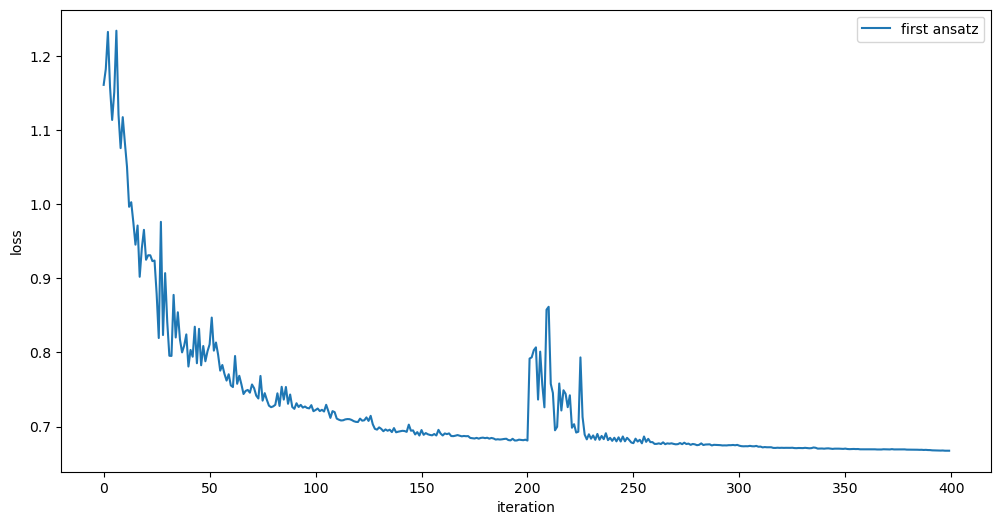

In [ ]:
obj_func_vals_first = objective_func_vals
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(obj_func_vals_first, label="first ansatz")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.legend()
plt.show()

### Testing and accuracy

We now interpret the results from training. We first test the training accuracy over the training set.

In [ ]:
import copy
from sklearn.metrics import accuracy_score
from qiskit.primitives import StatevectorEstimator as Estimator  # simulator
# from qiskit_ibm_runtime import EstimatorV2 as Estimator  # real quantum computer

#estimator = Estimator()
# estimator = Estimator(backend=backend)
estimator = estimatorV2(options={
    "backend_options": {
        "max_parallel_threads": 7,
        "max_memory_mb": 6000
    },
    "run_options": {
        "shots":10000  # cálculo exacto de expectativa
    },
}) 

pred_train = forward(circuit, np.array(X_train), res["x"], estimator, observable)
# pred_train = forward(circuit_ibm, np.array(train_images), res['x'], estimator, observable_ibm)

print(pred_train)

pred_train_labels = copy.deepcopy(pred_train)
pred_train_labels[pred_train_labels >= 0] = 1
pred_train_labels[pred_train_labels < 0] = -1
print(pred_train_labels)
print(train_labels)

accuracy = accuracy_score(train_labels, pred_train_labels)
print(f"Train accuracy: {accuracy * 100}%")

[ 0.09750714  0.08002379  0.15293046 -0.29835187  0.12721014 -0.43896605
  0.01107765  0.18014065 -0.09001379 -0.16219831  0.38182187 -0.03260395
  0.21631385  0.03602728 -0.17714674 -0.31748634 -0.09542136 -0.7051745
 -0.07021306 -0.36515063 -0.0245613  -0.46261418 -0.36069753 -0.31637838
 -0.18043807  0.14527871 -0.39446109  0.5294724  -0.03083707  0.12163604
 -0.42401054 -0.06327461  0.03873777 -0.26555196 -0.21114368 -0.27724499
 -0.23240801  0.41483217  0.04938622  0.14649465  0.59234668 -0.04552994
  0.26837424  0.25058419  0.47315518 -0.29669219 -0.59253635 -0.1853728
  0.19178383 -0.34636855 -0.19249488 -0.46792705 -0.13560762  0.1000346
 -0.35239405 -0.01275586]
[ 1.  1.  1. -1.  1. -1.  1.  1. -1. -1.  1. -1.  1.  1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1.  1. -1.  1. -1.  1. -1. -1.  1. -1. -1. -1.
 -1.  1.  1.  1.  1. -1.  1.  1.  1. -1. -1. -1.  1. -1. -1. -1. -1.  1.
 -1. -1.]
[ 1  1  1 -1  1 -1  1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1
 -1  1 -1  1 -1  1

In [ ]:
pred_test = forward(circuit, np.array(X_test), res["x"], estimator, observable)


print(pred_test)

pred_test_labels = copy.deepcopy(pred_test)
pred_test_labels[pred_test_labels >= 0] = 1
pred_test_labels[pred_test_labels < 0] = -1
print(pred_test_labels)
print(test_labels)

accuracy = accuracy_score(test_labels, pred_test_labels)
print(f"Test accuracy: {accuracy * 100}%")

[-3.40351846e-01  1.13742062e+00 -4.68358109e-01 -2.30055366e-02
  4.63779819e-04 -4.20875808e-01 -4.59319604e-02  3.62699579e-01
 -1.56829904e-01  7.19010909e-01 -1.40741509e-01  1.07027530e-01
  3.76350422e-02 -6.02401972e-01 -1.60167210e-01 -2.89347325e-01]
[-1.  1. -1. -1.  1. -1. -1.  1. -1.  1. -1.  1.  1. -1. -1. -1.]
[-1  1 -1 -1  1  1 -1  1 -1 -1 -1  1 -1 -1 -1 -1]
Test accuracy: 81.25%


and the accuracy on the test set is

The notebook is based on materials from various sources including  [IBM Quantum Learning](https://quantum.cloud.ibm.com/learning/en/courses/quantum-machine-learning). However, it has been significantly modified. The syntax is according to qiskit version 2.3.

Please cite/acknowledge my work when you use this notebook. Thanks. M. Faryad. [github/muf18](github.com/muf148)